## **Introduction to Image Processing**

## Interpolation and Blending

 Importing necessary libraries/modules and functions

In [3]:
% matplotlib inline
% pprint off


# Import the library as show images, plot, etc.
import matplotlib.pyplot as plt
# Import functionality for the color map
import matplotlib.cm as cm

# Import system specific parameters and function
import sys 

## Other plotting libraries
# import seaborn as sns

# Import the library to mange the matrix and array 
import numpy as np

# Importing image processing toolbox 
## Module to read, write,... 
from skimage import io
## Module to convert the image on 8 bits
from skimage import img_as_ubyte
## Module to convert the image to float
from skimage import img_as_float
## Module for color conversion 
from skimage import color
## Module image transform from skimage for resize 
from skimage import transform
## Module misc from scipy for resize 
from scipy import misc
## Module util from skimage 
from PIL import Image


Pretty printing has been turned ON


### ** Resizing an image size using different interpolation functions**

**1. ** Resize the lena or vibot image using nearest, bilinear and bicubic function.

You can define your function which accept the model and resize size from the user or just run a script.

In [4]:
def ImResize (im, method='nearest', size= 0.5):
    print 'The resize method is {}'.format(method)
    im_resize = misc.imresize(im, size, interp = method)
    return im_resize

The resize method is nearest


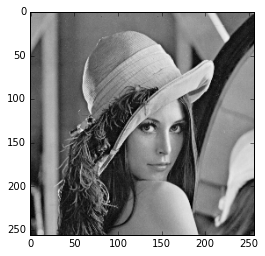

The resize method is bilinear


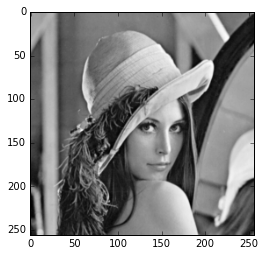

The resize method is bicubic


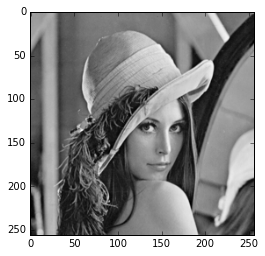

In [5]:
Path = './images/'
image_name = 'lena-grey.bmp'
lena_im = io.imread(Path.__add__(image_name))
lena_im = img_as_float(lena_im)
methods = ['nearest', 'bilinear', 'bicubic']
for m in methods:
    im_resize = ImResize(lena_im,m, 0.5)
    plt.figure
    plt.imshow(im_resize, cmap=plt.cm.gray)
    plt.show()  

**2. ** Similar to the function of `my_blending.m` that you saw before define your function of blending.

Blend the lena image and vibot image using simple, alpha and pyramid method.     

In [6]:
vibot_im = io.imread(Path.__add__('vibot-color.jpg'))
im_size = np.shape(vibot_im)
if(len(im_size)<3):
      print 'gray'
elif len(im_size)==3:
      print 'Color(RGB)'


Color(RGB)


Function that check if an image is Grey or Color :

In [7]:
def IsGrey(im):
    if len(im.shape)<3:
        print 'Image is in grey'
        check = True
    elif len(im.shape)==3:
        print 'Image is in color'
        check = False
    return check


Laplacian Pyramid function:

In [8]:
def Laplacian_pyramid(pyramid):
    Lpyramid= []
    for i in range (0, len(pyramid)):
        if i != len(pyramid)-1:
            upscalePyramid = transform.rescale(pyramid[i+1], 2, mode='constant')
            if upscalePyramid.shape == pyramid[i].shape:
                L = pyramid[i] - upscalePyramid
                Lpyramid.append(L)
                #print 'The original image and the upscale one has the size {}'.format(upscalePyramid.shape)
            else:
                upscalePyramid = upscalePyramid[:pyramid[i].shape[0], :pyramid[i].shape[1]]
                L = pyramid[i] - upscalePyramid
                Lpyramid.append(L)
                #print 'The upscale image is cropped to be the same size as the original image {}'.format(upscalePyramid.shape)
        else:
            L = pyramid[i]
            Lpyramid.append(L)
    return Lpyramid


Colapsing pyramid Function : 

$rescale(rescale(rescale(L_3)+L_2)+L_1)+L_0$

In [9]:
def colapse_pyramid(pyramid):
    Layer = len(pyramid)-1
    L = pyramid[Layer]
    while Layer != 0:      
        upscalePyramid = transform.rescale(L,2) 
        if upscalePyramid.shape == pyramid[Layer-1].shape:
            L = upscalePyramid + pyramid[Layer-1]
            Layer = Layer -1
        else:
            L = upscalePyramid[:pyramid[Layer-1].shape[0], :pyramid[Layer-1].shape[1]] + pyramid[Layer-1]
            Layer = Layer -1
    colapse_image = L         
    return colapse_image

In [10]:
def ImBlend(im1,im2, method='simple', win=10):
    im1 = img_as_float(im1)
    im2 = img_as_float(im2)
    if IsGrey(im1)== False:
        im1 = color.rgb2gray(im1)
    if IsGrey(im2)== False:
        im2 = color.rgb2gray(im2)
    
    if np.shape(im1) != np.shape(im2):
        raise ValueError('Images are not the same size.')
    else:
        row, col = np.shape(im1)
        blend_im = np.zeros((row,col))
    
        if method == 'simple':
            blend_im[:, :np.ceil(col/2)] = im1[:, :np.ceil(col/2)]
            blend_im[:, np.ceil(col/2):] = im2[:, np.ceil(col/2):]

        elif method == 'alpha':
            blend_im[:, :np.ceil(col/2)-win] = im1[:, :np.ceil(col/2)-win]
            blend_im[:, np.ceil(col/2)+win:] = im2[:, np.ceil(col/2)+win:]

            x1 = np.ceil(col/2)-win
            x2 = np.ceil(col/2)+win
            x  = np.arange(x1, x2)
            alpha = x/(x1-x2) -x2/(x1-x2); 
            #alpha = repmat(a , size(I3,1), 1);
            blend_im[:, x1:x2] = alpha* im1[:, x1:x2] + (1- alpha)* im2[:, x1:x2]

        elif method == 'pyramid':
            ## Create a region mask 
            mask = np.zeros(im1.shape)
            mask[:,:np.ceil(col/2)] = 1.0
            mask[:, np.ceil(col/2):] = 0.0
            
            ## Gaussian pyramid for im1 and im2   
            im1_GP = transform.pyramid_gaussian(im1, downscale=2)
            im1_GP = list(im1_GP)
            print len(im1_GP)
            #im1_GP = [a for a in im1_GP]
            im2_GP = transform.pyramid_gaussian(im2, downscale=2)
            im2_GP = [a for a in im2_GP]
            ## Laplacian pyramid using transform moudle  
            im1_LP = transform.pyramid_laplacian(im1, downscale=2)
            im1_LP = [a for a in im1_LP]
            im2_LP = transform.pyramid_laplacian(im2, downscale=2)
            im2_LP = [a for a in im2_LP]
            ## Laplacian pyramid using the equation of blending
            im1_LP1 = Laplacian_pyramid(im1_GP)
            im2_LP2 = Laplacian_pyramid(im2_GP)
             
            ## Gaussian pyramid for mask
            mask_GP = tuple(transform.pyramid_gaussian(mask, downscale=2))
            mask_GP = [a for a in mask_GP]
            
            ## Blending the two laplacian pyramid
            Blend_pyramid = []
            for i in range(0, len(mask_GP)):
                Blend_pyramid.append(im1_LP[i]*mask_GP[i] + im2_LP[i]*(1 - mask_GP[i]))
          
            ## Colapsing the blending pyramid 
            blend_im = colapse_pyramid(Blend_pyramid)
                
        else:
            print 'unknown method'
            
        
    return blend_im
    

In [11]:
orange_im = io.imread(Path.__add__('orange.jpeg'))
apple_im = io.imread(Path.__add__('apple.jpeg'))


In [12]:
blend_im1 = ImBlend(orange_im, apple_im)
blend_im2 = ImBlend(orange_im, apple_im, method = 'alpha')
blend_im3 = ImBlend(orange_im, apple_im, method = 'pyramid')

Image is in color
Image is in color
Image is in color
Image is in color
Image is in color
Image is in color


/home/lemaitre/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/lemaitre/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/lemaitre/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/lemaitre/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/lemaitre/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/lemaitre/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3

10


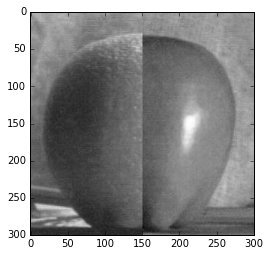

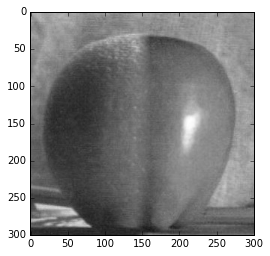

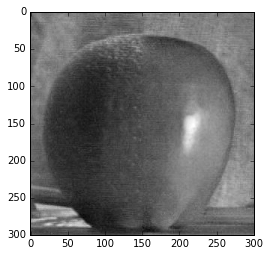

In [13]:
plt.figure
plt.imshow(blend_im1, cmap=plt.cm.gray)
plt.show()

plt.figure
plt.imshow(blend_im2, cmap=plt.cm.gray)
plt.show()

plt.figure
plt.imshow(blend_im3, cmap=plt.cm.gray)
plt.show()

